In [2]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data/redux'

In [17]:
#Allow relative imports to directories above lesson1/
# I needed to modify this to point to the utils subdirectory ... didn't work
# exactly out of the box but it's ok
sys.path.insert(1, os.path.join(sys.path[0], '../utils'))

#import modules
from utils import *
from vgg16 import Vgg16

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

In [31]:
# I just created directories using command line tools - this time - can try
# again for the next lesson

In [34]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/' #'/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

/home/ubuntu/courses/deeplearning1/lesson1/data/redux


In [36]:
vgg = Vgg16()
batch_size=64
no_of_epochs=3

In [37]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.01

Found 24800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [38]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print "Running epoch: %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print "Completed %s fit operations" % no_of_epochs

Running epoch: 0
Epoch 1/1
24800/24800 [==============================] - 661s - loss: 0.3364 - acc: 0.9711 - val_loss: 0.5989 - val_acc: 0.9600
Running epoch: 1
Epoch 1/1
24800/24800 [==============================] - 666s - loss: 0.3259 - acc: 0.9762 - val_loss: 0.4854 - val_acc: 0.9700
Running epoch: 2
Epoch 1/1
24800/24800 [==============================] - 665s - loss: 0.3332 - acc: 0.9767 - val_loss: 0.6026 - val_acc: 0.9550
Completed 3 fit operations


In [41]:
# Time to test!
batches, preds = vgg.test(test_path, batch_size = batch_size*2)


Found 12500 images belonging to 1 classes.


In [72]:
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

In [74]:
# Now we go on to data exploration

In [75]:
vgg.model.load_weights(results_path+latest_weights_filename)

In [76]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 200 images belonging to 2 classes.


In [78]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [79]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 192 correct labels


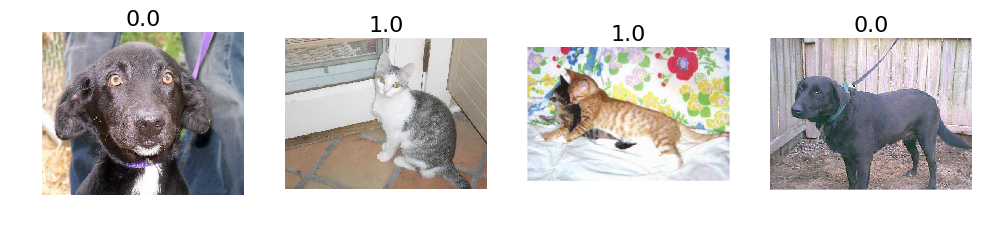

In [84]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 8 incorrect labels


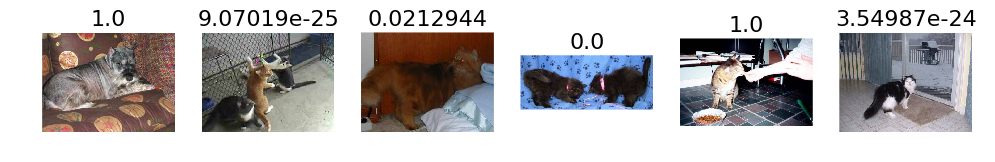

In [97]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:6]
plots_idx(idx, our_predictions[idx])

In [94]:
our_predictions[172]

1.0

In [99]:
filenames[172] # is not actually a dog, it's really a cat!

'dogs/dog.11731.jpg'

Found 94 confident correct cats labels


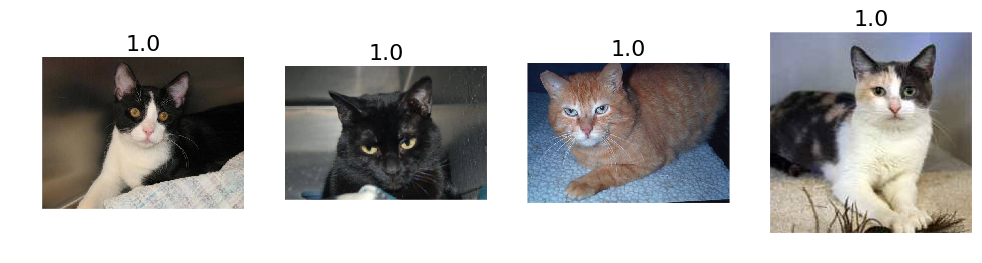

In [100]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print "Found %d confident correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 98 confident correct dogs labels


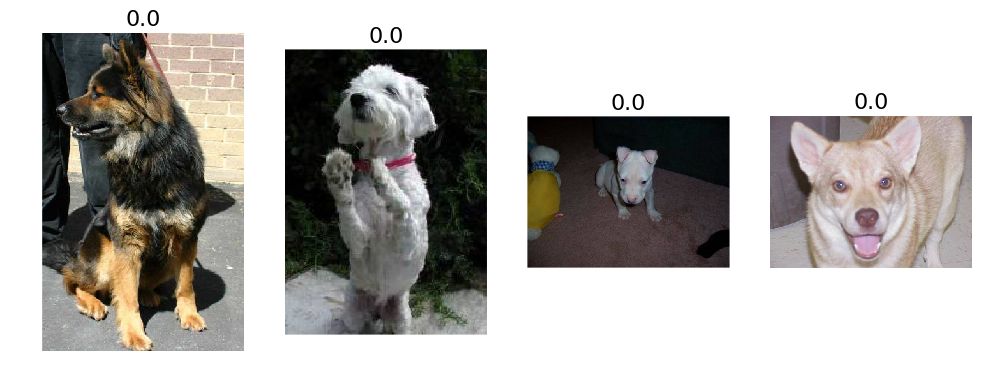

In [101]:
#3b. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print "Found %d confident correct dogs labels" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Found 2 incorrect cats


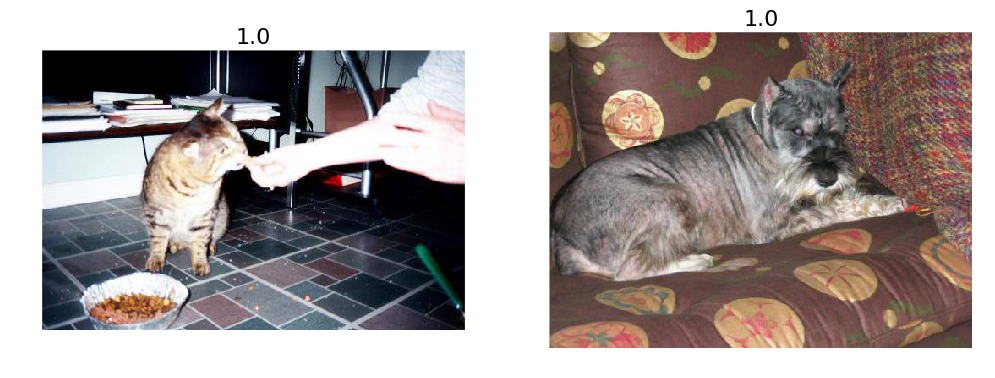

In [102]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found %d incorrect cats" % len(incorrect_cats)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 6 incorrect dogs


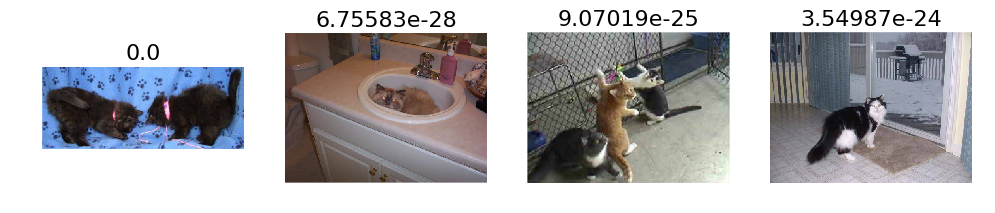

In [103]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print "Found %d incorrect dogs" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

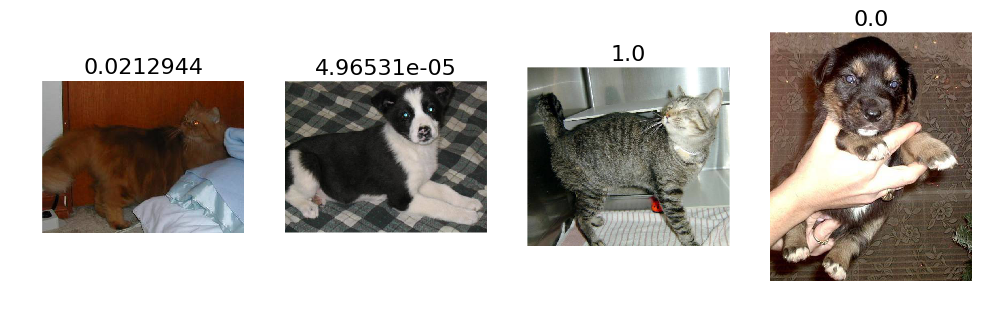

In [105]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

In [106]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

[[94  6]
 [ 2 98]]


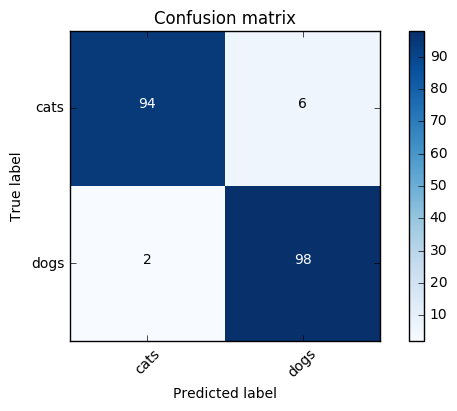

In [107]:
plot_confusion_matrix(cm, val_batches.class_indices)

In [109]:
#Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [110]:
#Grab the dog prediction column
isdog = preds[:,1]
print "Raw Predictions: " + str(isdog[:5])
print "Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)])
print "Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)])

Raw Predictions: [ 0.      0.0124  0.      0.      1.    ]
Mid Predictions: [ 0.5081  0.5629  0.4071  0.5305]
Edge Predictions: [ 0.  0.  0. ...,  0.  0.  1.]


In [116]:
#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05
isdog = isdog.clip(min=0.05, max=0.95)

In [117]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [118]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  9.2920e+03,   5.0000e-02],
       [  1.2026e+04,   5.0000e-02],
       [  9.6880e+03,   5.0000e-02],
       [  4.3920e+03,   5.0000e-02],
       [  7.7900e+02,   9.5000e-01]])

In [119]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

/home/ubuntu/courses/deeplearning1/lesson1/data/redux


In [120]:
from IPython.display import FileLink
%cd $LESSON_HOME_DIR
FileLink('data/redux/'+submission_file_name)

/home/ubuntu/courses/deeplearning1/lesson1


/home/ubuntu/courses/deeplearning1/lesson1/data/redux/submission1.csv